In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

(100, 1000)


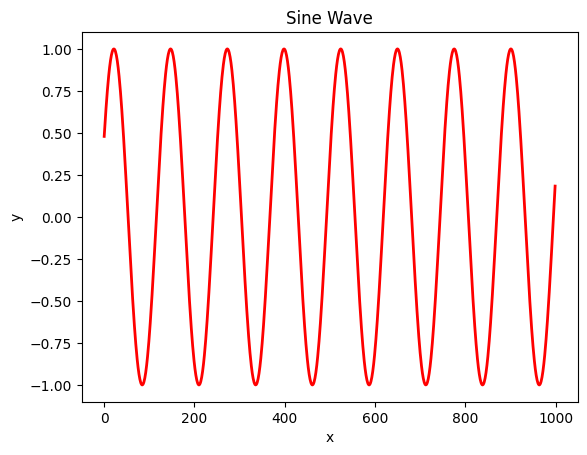

In [15]:
N = 100     # number of sample
L = 1000    # lenght of sinwave
T = 20      # peroid of wave

x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4+T, N).reshape(N, 1)
y = np.sin(x/1.0/T).astype(np.float32)
print(x.shape)


plt.title('Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(np.arange(x.shape[1]), y[0, :], 'r', linewidth=2.0)


In [4]:
# Setup Architechture
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden= 51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
        
        
    def forward(self, x, future= 0):
        outputs = []
        n_samples = x.size(0)
        
        h_t = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32)
        
        # to get initial output
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # to get next output    
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim= 1)
        return outputs
            

In [16]:
if __name__ == '__main__':
    train_input = torch.from_numpy(y[3:, :-1])
    train_target = torch.from_numpy(y[3:, 1:])
    
    test_input = torch.from_numpy(y[:3, :-1])
    test_target = torch.from_numpy(y[:3, 1:])
    
    model = LSTMPredictor()
    criterion = nn.MSELoss()
    
    optimizer = optim.LBFGS(model.parameters(), lr= 0.8)
    
    n_steps = 10
    for i in range(n_steps):
        print(f'Step {i}')
        
        def closure():
            optimizer.zero_grad()
            out = model(train_input)
            loss = criterion(out, train_target)
            print(f"Train Loss: {loss.item()}")
            
            loss.backward()
            return loss
        optimizer.step(closure)
        
        with torch.no_grad():
            future= 1000
            pred= model(test_input, future= future)
            loss = criterion(pred[:, :-future], test_target)
            print(f"Test Loss: {loss.item()}")
            
            y= pred.detach().numpy()
            
        plt.title(f'Step {i+1}')
        n = train_input.shape[1]
        
        def draw(y_i, color):
            plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
            plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0)
            
        
        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        
        plt.savefig(f'predicts{i}.pdf')
        plt.close()
        
        

Step 0
Train Loss: 0.4979020655155182
Train Loss: 0.49371975660324097
Train Loss: 0.467023640871048
Train Loss: 0.4240017235279083
Train Loss: 0.4815312922000885
Train Loss: 0.21518844366073608
Train Loss: 0.046211790293455124
Train Loss: 0.055941805243492126
Train Loss: 0.02467946708202362
Train Loss: 0.024350149556994438
Train Loss: 0.02371853217482567
Train Loss: 0.02237296849489212
Train Loss: 0.019745225086808205
Train Loss: 0.015569375827908516
Train Loss: 0.008755392394959927
Train Loss: 0.003983911592513323
Train Loss: 0.0033171505201607943
Train Loss: 0.0026171738281846046
Train Loss: 0.002027719048783183
Train Loss: 0.0016753735253587365
Test Loss: 0.0016336663393303752
Step 1
Train Loss: 0.0015903156017884612
Train Loss: 0.0015142436604946852
Train Loss: 0.0013871139381080866
Train Loss: 0.0012878444977104664
Train Loss: 0.001168076298199594
Train Loss: 0.0011160128051415086
Train Loss: 0.0010967691196128726
Train Loss: 0.001065122545696795
Train Loss: 0.000993102672509849
T